## Libraries

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.patches import Ellipse

import plotly.express as px
import plotly.graph_objects as go

from itertools import combinations
from scipy import stats
from scipy.io import loadmat, whosmat
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from scipy.linalg import inv

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from statsmodels.multivariate.manova import MANOVA

import pywt

import src
from src import config, loadmatNina
from src.preprocessing_utils import get_envelope

In [2]:
def calculate_emg_metrics(signal, fs=20):
    """
    Calculates various metrics for an EMG signal.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav,
        "IAV": iav,
        "RMS": rms,
        "WL": wl,
        "ZC": zc,
        "SSC": ssc,
        "VAR": var,
        "CoV": cov,
        "MNF": mnf,
        "mDWT": mdwt,
        "TD": td,
        "MAVS": mavs
    }
    
    return metrics

def calculate_emg_metrics_std(signal, fs=20):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    if signal.ndim == 2:
        metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
        averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
        return averaged_metrics
    
    # Mean Absolute Value (MAV)
    mav = np.mean(np.abs(signal))
    mav_std = np.std(np.abs(signal))
    
    # Integrated Absolute Value (IAV)
    iav = np.sum(np.abs(signal))
    iav_std = np.std(np.abs(signal))
    
    # Root Mean Square (RMS)
    rms = np.sqrt(np.mean(signal**2))
    rms_std = np.std(signal)
    
    # Waveform Length (WL)
    wl = np.sum(np.abs(np.diff(signal)))
    wl_std = np.std(np.abs(np.diff(signal)))
    
    # Zero Crossings (ZC)
    zc = np.sum(np.diff(np.sign(signal)) != 0)
    zc_std = np.std(np.diff(np.sign(signal)) != 0)
    
    # Slope Sign Changes (SSC)
    diff_signal = np.diff(signal)
    ssc = np.sum((diff_signal[1:] * diff_signal[:-1]) < 0)
    ssc_std = np.std((diff_signal[1:] * diff_signal[:-1]) < 0)
    
    # Variance (VAR)
    var = np.var(signal)
    var_std = np.std(signal)
    
    # Coefficient of Variation (CoV)
    mean_signal = np.mean(signal)
    cov = (np.std(signal) / mean_signal) if mean_signal != 0 else 0
    cov_std = np.std(cov)
    
    # Mean Frequency (MNF)
    freqs = np.fft.rfftfreq(len(signal), d=1/fs)
    fft_magnitude = np.abs(np.fft.rfft(signal))
    mnf = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
    mnf_std = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude)
    
    # Marginal Discrete Wavelet Transform (mDWT)
    coeffs = pywt.wavedec(signal, 'db4', level=4)
    mdwt = np.sum([np.sum(np.abs(c)) for c in coeffs])
    mdwt_std = np.std([np.sum(np.abs(c)) for c in coeffs])
    
    # Temporal Difference (TD)
    td = np.sum(np.abs(np.diff(signal)))
    td_std = np.std(np.abs(np.diff(signal)))
    
    # Mean Absolute Value Slope (MAVS)
    mavs = np.mean(np.abs(np.diff(signal)))
    mavs_std = np.std(np.abs(np.diff(signal)))
    
    # Return the metrics as a dictionary
    metrics = {
        "MAV": mav, "MAV_STD": mav_std,
        "IAV": iav, "IAV_STD": iav_std,
        "RMS": rms, "RMS_STD": rms_std,
        "WL": wl, "WL_STD": wl_std,
        "ZC": zc, "ZC_STD": zc_std,
        "SSC": ssc, "SSC_STD": ssc_std,
        "VAR": var, "VAR_STD": var_std,
        "CoV": cov, "CoV_STD": cov_std,
        "MNF": mnf, "MNF_STD": mnf_std,
        "mDWT": mdwt, "mDWT_STD": mdwt_std,
        "TD": td, "TD_STD": td_std,
        "MAVS": mavs, "MAVS_STD": mavs_std
    }
    
    return metrics

def calculate_emg_metrics_means(signal, fs=20):
    """
    Calculates various metrics for an EMG signal, including mean and standard deviation.

    Parameters:
    - signal: NumPy array containing the EMG signal.
    - fs: Sampling frequency in Hz (default: 1000 Hz).

    Returns:
    - A dictionary with the computed metrics.
    """
    try:
        if signal.ndim == 2:
            metrics_per_channel = [calculate_emg_metrics(signal[:, ch], fs) for ch in range(signal.shape[1])]
            averaged_metrics = {key: np.mean([m[key] for m in metrics_per_channel]) for key in metrics_per_channel[0]}
            return averaged_metrics
        
        abs_signal = np.abs(signal)
        diff_signal = np.diff(signal)
        diff_abs_signal = np.abs(diff_signal)
        
        # Compute Metrics
        metrics = {
            "MAV": np.mean(abs_signal), "MAV_STD": np.std(abs_signal),
            "IAV": np.sum(abs_signal), "IAV_STD": np.std(abs_signal),
            "RMS": np.sqrt(np.mean(signal**2)), "RMS_STD": np.std(signal),
            "WL": np.sum(diff_abs_signal), "WL_STD": np.std(diff_abs_signal),
            "ZC": np.sum(np.diff(np.sign(signal)) != 0), "ZC_STD": np.std(np.diff(np.sign(signal)) != 0),
            "SSC": np.sum((diff_signal[1:] * diff_signal[:-1]) < 0), "SSC_STD": np.std((diff_signal[1:] * diff_signal[:-1]) < 0),
            "VAR": np.var(signal), "VAR_STD": np.std(signal),
            "CoV": (np.std(signal) / np.mean(signal)) if np.mean(signal) != 0 else 0,
            "TD": np.sum(diff_abs_signal), "TD_STD": np.std(diff_abs_signal),
            "MAVS": np.mean(diff_abs_signal), "MAVS_STD": np.std(diff_abs_signal),
            "MNP": np.mean(signal**2), "MNP_STD": np.std(signal**2),
        }
        
        # Spectral Metrics
        freqs = np.fft.rfftfreq(len(signal), d=1/fs)
        fft_magnitude = np.abs(np.fft.rfft(signal))
        metrics["MNF"] = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        metrics["MNF_STD"] = np.std(freqs * fft_magnitude) / np.sum(fft_magnitude) if np.sum(fft_magnitude) != 0 else 0
        
        # Wavelet Transform
        coeffs = pywt.wavedec(signal, 'db4', level=4)
        mdwt_values = np.array([np.sum(np.abs(c)) for c in coeffs])
        metrics["mDWT"] = np.sum(mdwt_values)
        metrics["mDWT_STD"] = np.std(mdwt_values)
        
        # Kurtosis
        std_signal = np.std(signal)
        metrics["Kurt"] = np.mean((signal - np.mean(signal)) ** 4) / (std_signal ** 4) if std_signal != 0 else 0
        metrics["Kurt_STD"] = np.std(metrics["Kurt"])
        
        return metrics
    
    except Exception as e:
        print(f"Error in calculate_emg_metrics: {e}")
        return {}

def apply_hanning_window(signal, window_size):
        if len(signal) < window_size:
            raise ValueError(f"Signal length ({len(signal)}) must be greater than or equal to the window size ({window_size}).")
        window = np.hanning(window_size)
        return np.convolve(signal, window / window.sum(), mode='same')


In [3]:
# Choose the database to analyze
database = 'ArmbandDB0'
file = 'TKEO_multichannel_processed_20250420_225540.parquet'
total_subjects = 8

# List of subjects, generating names from 's1' to 's10'
subjects = [f's{i}' for i in range(1, total_subjects + 1)]

data_path = f'data/{database}/{file}'
# Check if the file exists
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The file {data_path} does not exist.")

df = pd.read_parquet(data_path)
# Display original data structure
print("Original DataFrame columns:")
print(df.columns.tolist())
print("\nOriginal DataFrame head:")
display(df.head())


Original DataFrame columns:
['ax', 'ay', 'az', 'gx', 'gy', 'gz', 't', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 'Name', 'Grasp', 'ObjectID', 'Timestamp', 'grasp']

Original DataFrame head:


,ax,ay,az,gx,gy,gz,t,s1,s2,s3,s4,s5,s6,s7,s8,Name,Grasp,ObjectID,Timestamp,grasp
0,-0.021683,-0.059170,0.007318,-1.008630,2.751827,0.137329,0.0,4.772117e-18,5.893932e-16,1.038811e-15,1.010044e-20,5.576670e-104,0.000000e+00,5.553646e-159,3.024697e-18,Daniela,Cilindric,1,2024-08-23 18:07:10,0
1,-0.026932,-0.052944,0.007807,-0.589013,3.301144,0.137329,0.0,4.772117e-18,8.410064e-16,1.272119e-15,1.010044e-20,7.267045e-104,3.025421e-19,6.175159e-159,3.024697e-18,Daniela,Cilindric,1,2024-08-23 18:07:10,0
2,-0.019485,-0.055386,0.006220,-0.276208,4.735470,0.137329,0.0,4.772117e-18,1.109679e-15,1.465704e-15,1.010044e-20,8.873224e-104,9.745574e-19,6.429883e-159,3.024697e-18,Daniela,Cilindric,1,2024-08-23 18:07:10,0
3,-0.029129,-0.058071,0.007807,-1.062036,1.286983,0.137329,0.0,4.772117e-18,1.370161e-15,1.587421e-15,1.010044e-20,1.019431e-103,2.040546e-18,6.429883e-159,3.024697e-18,Daniela,Cilindric,1,2024-08-23 18:07:10,0
4,-0.018021,-0.050869,0.006708,-0.390649,4.918575,0.137329,0.0,4.772117e-18,1.591338e-15,1.604478e-15,1.010044e-20,1.100718e-103,3.487844e-18,6.429883e-159,3.024697e-18,Daniela,Cilindric,1,2024-08-23 18:07:10,0


In [4]:
# Calculate repetition number
def calculate_repetition(data):
    """
    Calculate repetition numbers for each subject based on transitions to grasp 0.
    
    A new repetition starts when:
    1. The subject first appears in the data
    2. The grasp transitions from any non-zero value to 0
    
    Args:
        data: DataFrame containing 'subject' and 'restimulus' columns
        
    Returns:
        Series with repetition numbers
    """
    repetition = []
    current_repetitions = {}  # Track repetition count per subject
    previous_grasp = {}       # Track previous grasp per subject
    last_different_grasp = {}  # Track last different grasp per subject
    
    # Iterate through the DataFrame row by row
    for idx, (subject, grasp) in enumerate(zip(data['subject'], data['restimulus'])):
        # Initialize tracking for new subjects
        if subject not in current_repetitions:
            current_repetitions[subject] = 0
            previous_grasp[subject] = None
        
        # Check for transition from zero grasp to grasp
        if previous_grasp.get(subject) is not None and previous_grasp[subject] == 0 and grasp > 0:
            if last_different_grasp.get(subject) is None or last_different_grasp[subject] != grasp:
                current_repetitions[subject] = 0
                last_different_grasp[subject] = grasp

            current_repetitions[subject] += 1
            
        # Store the repetition number
        repetition.append(current_repetitions[subject])
        
        # Update the previous grasp
        previous_grasp[subject] = grasp
            
    return pd.Series(repetition, index=data.index)

def filter_outliers_in_grasp_zero(df, channel_cols, threshold_factor=2.0, window_size=10):
    filtered_df = df.copy()
    
    for subject in filtered_df['subject'].unique():
        # Get only grasp 0 data for this subject
        mask = (filtered_df['subject'] == subject) & (filtered_df['restimulus'] == 0)
        
        if not filtered_df.loc[mask].empty:
            for channel in channel_cols:
                # Extract just the data we need
                data = filtered_df.loc[mask, channel]
                
                # Calculate rolling mean
                rolling_mean = data.rolling(window=window_size, min_periods=1).mean()
                
                # Replace values that are outliers
                filtered_df.loc[mask, channel] = np.where(
                    data > threshold_factor * rolling_mean,
                    rolling_mean,
                    data
                )
    
    return filtered_df

In [5]:
combined_df = df.copy()

# Step 1: Encode 'Name' to 'subject' with numeric values from 1-8
# Create a mapping dictionary of unique names to numbers 1-8
unique_names = combined_df['Name'].unique()
name_to_num = {name: f"s{i+1}" for i, name in enumerate(unique_names)}

# Replace names with encoded values
combined_df['subject'] = combined_df['Name'].map(name_to_num)

# Step 2: Rename 'grasp' column to 'restimulus'
combined_df.rename(columns={'grasp': 'restimulus'}, inplace=True)

# Step 3: Delete 'object_id' column
if 'object_id' in combined_df.columns:
    combined_df.drop('object_id', axis=1, inplace=True)

# Step 4: Rename sensor columns from 's1'-'s8' to 'Channel 1'-'Channel 8'
sensor_cols = [f's{i}' for i in range(1, 9)]
new_cols = [f'Channel {i}' for i in range(1, 9)]
col_mapping = dict(zip(sensor_cols, new_cols))
combined_df.rename(columns=col_mapping, inplace=True)

# Step 5: Add required columns for compatibility
if 'Time (s)' not in combined_df.columns:
    # Calculate time based on the index and sampling rate (assuming 20Hz)
    combined_df['Time (s)'] = combined_df.index / 20.0

# Add 'relabeled' column (same as restimulus for now)
if 'relabeled' not in combined_df.columns:
    combined_df['relabeled'] = combined_df['restimulus']

# Step 6: Remove the original 'Name' column (optional)
combined_df.drop('Name', axis=1, inplace=True)

# Step 7: Add repetition number column
# Apply the function to calculate repetition numbers
combined_df['repetition'] = calculate_repetition(combined_df)

# Display the transformed DataFrame
print("\nTransformed DataFrame columns:")
print(combined_df.columns.tolist())
print("\nTransformed DataFrame head:")
display(combined_df.head())



Transformed DataFrame columns:
['ax', 'ay', 'az', 'gx', 'gy', 'gz', 't', 'Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5', 'Channel 6', 'Channel 7', 'Channel 8', 'Grasp', 'ObjectID', 'Timestamp', 'restimulus', 'subject', 'Time (s)', 'relabeled', 'repetition']

Transformed DataFrame head:


,ax,ay,az,gx,gy,gz,t,Channel 1,Channel 2,Channel 3,...,Channel 7,Channel 8,Grasp,ObjectID,Timestamp,restimulus,subject,Time (s),relabeled,repetition
0,-0.021683,-0.059170,0.007318,-1.008630,2.751827,0.137329,0.0,4.772117e-18,5.893932e-16,1.038811e-15,...,5.553646e-159,3.024697e-18,Cilindric,1,2024-08-23 18:07:10,0,s1,0.00,0,0
1,-0.026932,-0.052944,0.007807,-0.589013,3.301144,0.137329,0.0,4.772117e-18,8.410064e-16,1.272119e-15,...,6.175159e-159,3.024697e-18,Cilindric,1,2024-08-23 18:07:10,0,s1,0.05,0,0
2,-0.019485,-0.055386,0.006220,-0.276208,4.735470,0.137329,0.0,4.772117e-18,1.109679e-15,1.465704e-15,...,6.429883e-159,3.024697e-18,Cilindric,1,2024-08-23 18:07:10,0,s1,0.10,0,0
3,-0.029129,-0.058071,0.007807,-1.062036,1.286983,0.137329,0.0,4.772117e-18,1.370161e-15,1.587421e-15,...,6.429883e-159,3.024697e-18,Cilindric,1,2024-08-23 18:07:10,0,s1,0.15,0,0
4,-0.018021,-0.050869,0.006708,-0.390649,4.918575,0.137329,0.0,4.772117e-18,1.591338e-15,1.604478e-15,...,6.429883e-159,3.024697e-18,Cilindric,1,2024-08-23 18:07:10,0,s1,0.20,0,0


In [6]:
# Display the result to verify
print("Repetition counts by subject:")
display(combined_df.groupby(['subject', 'repetition']).size().unstack())

# Sample data to verify repetition logic
sample = combined_df.groupby(['subject']).apply(
    lambda x: x.loc[x.index[:20], ['restimulus', 'repetition']]
).reset_index(drop=True).head(20)

print("\nSample data showing grasp transitions and repetition counts:")
display(sample)

Repetition counts by subject:


repetition,0,1,2,3,4,5
subject,,,,,,
s1,264,3389,2008,2184,2523,3818
s2,299,2442,2539,2534,2532,4460
s3,287,2528,2544,2533,2488,3857
s4,195,2315,2277,2573,591,672
s5,276,2280,2748,2556,2502,3947
s6,353,2590,2746,2630,2213,5965
s7,616,2192,2664,2365,2354,5473
s8,486,2418,2515,2542,2513,3837



Sample data showing grasp transitions and repetition counts:


,restimulus,repetition
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [7]:
# List of EMG channel columns
emg_channels = [col for col in combined_df.columns if "Channel" in col]

# Apply the filter
filtered_combined_df = filter_outliers_in_grasp_zero(
    combined_df, 
    emg_channels, 
    threshold_factor=1.25,  # Adjust this based on your data
    window_size=100
)

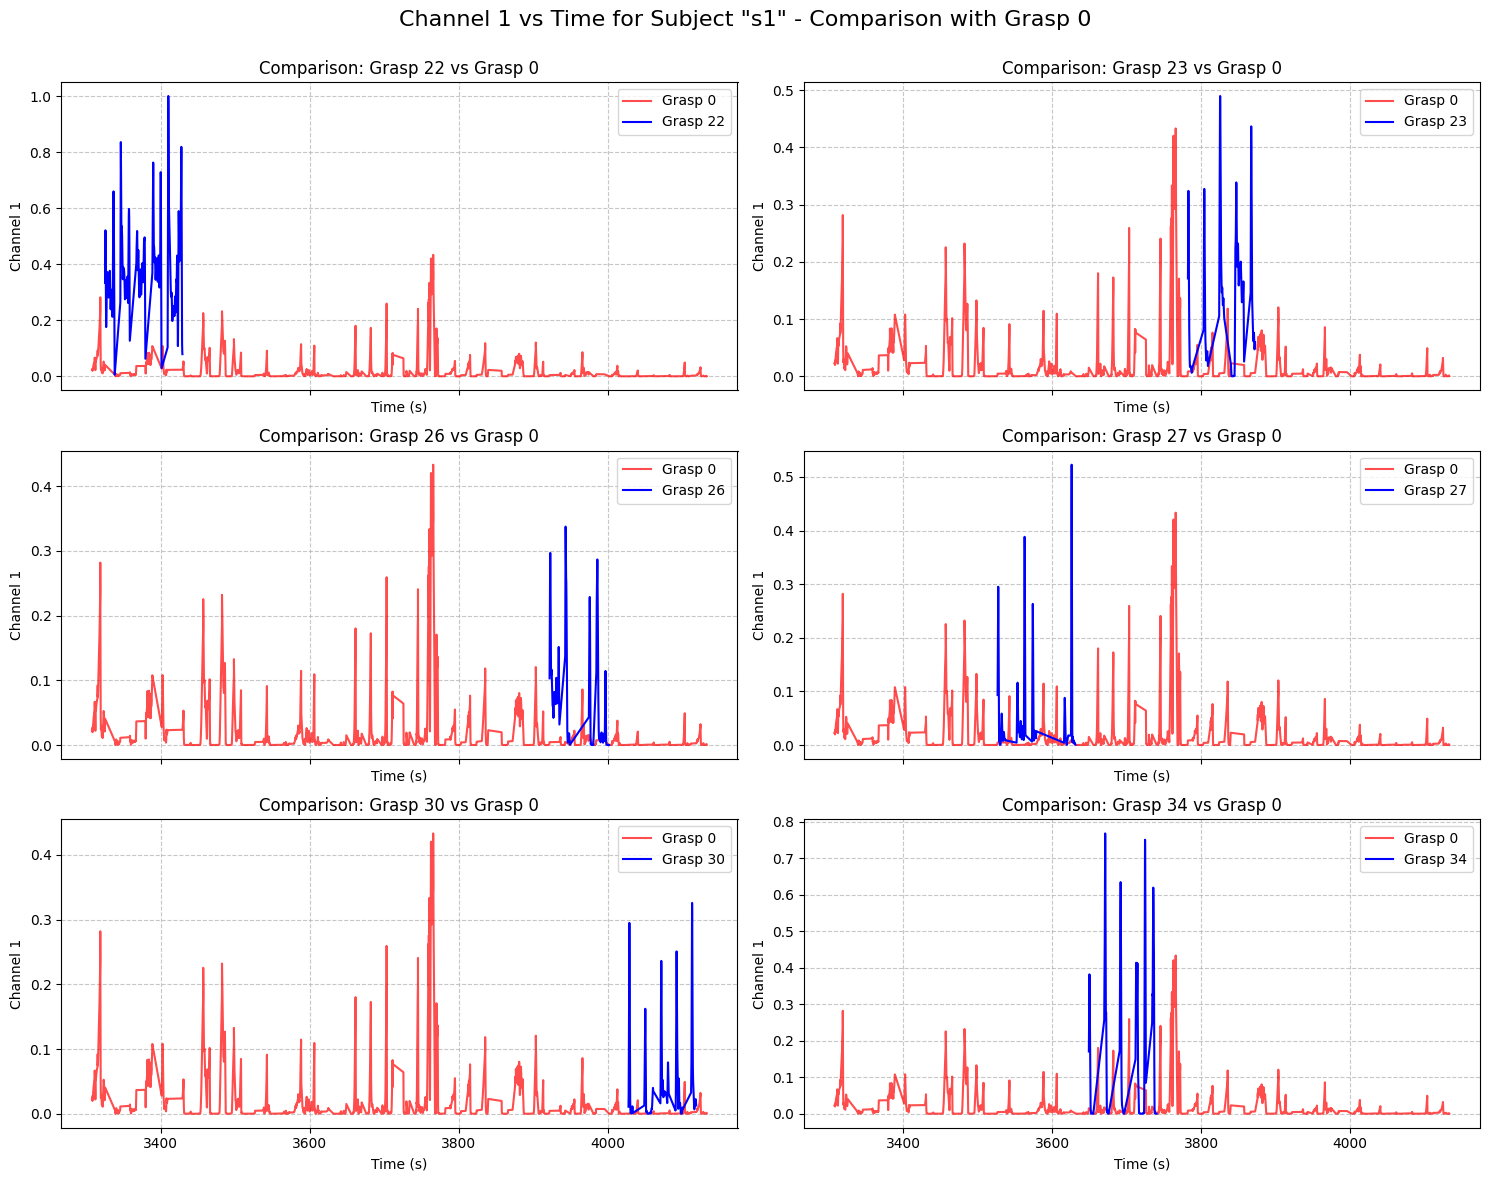

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Filter the DataFrame for the subject (s1)
data = filtered_combined_df[filtered_combined_df['subject'] == "s6"]

# Get unique grasps for this subject, excluding 0 for now
unique_grasps = sorted([g for g in data['restimulus'].unique() if g != 0])

# Reference data for grasp 0
grasp0_data = data[data['restimulus'] == 0]

if grasp0_data.empty:
    print("No data available for grasp 0")
else:
    # Calculate grid dimensions
    n_grasps = len(unique_grasps)
    n_cols = 2  # You can adjust this
    n_rows = math.ceil(n_grasps / n_cols)

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), sharex=True)
    axes = axes.flatten() if n_grasps > 1 else [axes]

    # Plot each grasp in a separate subplot, alongside grasp 0
    for i, grasp in enumerate(unique_grasps):
        if i < len(axes):
            grasp_data = data[data['restimulus'] == grasp]
            
            # Plot grasp 0 in each subplot (in a consistent color)
            axes[i].plot(grasp0_data['Time (s)'], grasp0_data['Channel 1'], 
                      color='red', label=f'Grasp 0', alpha=0.7)
            
            # Plot the other grasp in blue
            axes[i].plot(grasp_data['Time (s)'], grasp_data['Channel 1'], 
                      color='blue', label=f'Grasp {grasp}')
            
            axes[i].set_title(f'Comparison: Grasp {grasp} vs Grasp 0')
            axes[i].set_xlabel('Time (s)')
            axes[i].set_ylabel('Channel 1')
            axes[i].grid(True, linestyle='--', alpha=0.7)
            axes[i].legend()

    # Remove any unused subplots
    for i in range(n_grasps, len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle('Channel 1 vs Time for Subject "s1" - Comparison with Grasp 0', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)  # Make room for the title
    plt.show()

In [9]:
# Save the preprocessed DataFrame
processed_path = 'data/ArmbandDB0/preprocessed_data.parquet'
filtered_combined_df.to_parquet(processed_path)
print(f"\nSaved preprocessed data to {processed_path}")


Saved preprocessed data to data/ArmbandDB0/preprocessed_data.parquet


## Metrics with std for every channel, for every grasp

In [11]:
metrics_data = []

# Iterate over each subject, grasp (relabeled), and repetition
for (subject, relabeled, repetition), group in filtered_combined_df.groupby(['subject', 'relabeled', 'repetition']):
    for channel in group.columns:
        if channel.startswith('Channel'):
            channel_signal = group[channel].values
            metrics = calculate_emg_metrics_means(channel_signal)

            metrics_data.append({
                "subject": subject,
                "relabeled": relabeled,
                "repetition": repetition,
                "channel": channel,
                **metrics
            })

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Reorder columns (optional)
column_order = ["subject", "relabeled", "repetition", "channel"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Display
print("\nMetrics DataFrame by Channel, Subject, Relabeled, Repetition:")
display(metrics_df)


C:\Users\escob\AppData\Local\Temp\ipykernel_32572\1260256792.py:208: RuntimeWarning: invalid value encountered in scalar divide
  metrics["Kurt"] = np.mean((signal - np.mean(signal)) ** 4) / (std_signal ** 4) if std_signal != 0 else 0



Metrics DataFrame by Channel, Subject, Relabeled, Repetition:


,subject,relabeled,repetition,channel,MAV,MAV_STD,IAV,IAV_STD,RMS,RMS_STD,...,MAVS,MAVS_STD,MNP,MNP_STD,MNF,MNF_STD,mDWT,mDWT_STD,Kurt,Kurt_STD
0,s1,0,0,Channel 1,2.027508e-06,7.921044e-06,5.352622e-04,7.921044e-06,8.176412e-06,7.921044e-06,...,2.139031e-07,7.861388e-07,6.685372e-11,3.504396e-10,2.513061,0.003962,5.005634e-04,1.702535e-04,26.966984,0.0
1,s1,0,0,Channel 2,7.959430e-05,3.907906e-04,2.101290e-02,3.907906e-04,3.988139e-04,3.907906e-04,...,1.596259e-05,9.560992e-05,1.590526e-07,1.311514e-06,3.172577,0.006545,3.745184e-02,9.820078e-03,68.370691,0.0
2,s1,0,0,Channel 3,1.443399e-04,7.914741e-04,3.810574e-02,7.914741e-04,8.045279e-04,7.914741e-04,...,3.170729e-05,1.838385e-04,6.472652e-07,5.333436e-06,3.128727,0.006152,7.461119e-02,2.067863e-02,67.728231,0.0
3,s1,0,0,Channel 4,2.966716e-08,1.108673e-07,7.832130e-06,1.108673e-07,1.147680e-07,1.108673e-07,...,2.585221e-09,8.907882e-09,1.317170e-14,6.310349e-14,2.301707,0.003134,6.780148e-06,2.236342e-06,22.325375,0.0
4,s1,0,0,Channel 5,4.164709e-93,1.689849e-92,1.099483e-90,1.689849e-92,1.740413e-92,1.689849e-92,...,5.884107e-94,2.893515e-93,3.029038e-184,0.000000e+00,2.881807,0.005194,1.367412e-90,3.992421e-91,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,s8,34,5,Channel 4,4.264440e-01,1.769262e-01,1.031994e+02,1.769262e-01,4.616897e-01,1.769262e-01,...,9.813390e-03,1.147484e-02,2.131573e-01,1.816062e-01,0.650116,0.002850,3.778920e+01,1.351590e+01,4.194595,0.0
2228,s8,34,5,Channel 5,6.970468e-01,2.504128e-01,1.686853e+02,2.504128e-01,7.406624e-01,2.504128e-01,...,1.374718e-02,1.490659e-02,5.485808e-01,2.810552e-01,0.285983,0.003014,4.968704e+01,1.834734e+01,3.414316,0.0
2229,s8,34,5,Channel 6,3.937894e-01,2.044131e-01,9.529704e+01,2.044131e-01,4.436832e-01,2.044131e-01,...,8.131708e-03,1.256075e-02,1.968548e-01,2.418517e-01,0.291184,0.003186,3.381606e+01,1.227853e+01,5.292898,0.0
2230,s8,34,5,Channel 7,1.246102e-01,2.375653e-01,3.015567e+01,2.375653e-01,2.682629e-01,2.375653e-01,...,7.814735e-03,1.345464e-02,7.196499e-02,1.823120e-01,0.465519,0.004945,1.302901e+01,4.215793e+00,5.975582,0.0


In [12]:
# Compute mean and std of each metric grouped by subject, relabeled, repetition, and channel
df_mean = metrics_df.groupby(['subject', 'relabeled', 'repetition', 'channel']).mean(numeric_only=True)
df_std = metrics_df.groupby(['subject', 'relabeled', 'repetition', 'channel']).std(numeric_only=True)

# Reset index so 'channel' is a column again
df_mean = df_mean.reset_index()
df_std = df_std.reset_index()

# Melt both into long format (optional — but good for clarity)
# Not strictly necessary, but safer if merging multiple stats

# Merge mean and std DataFrames on all keys
df_result = df_mean.merge(df_std, on=['subject', 'relabeled', 'repetition', 'channel'], suffixes=('_mean', '_std'))

# Now pivot the DataFrame to get your desired column naming
df_pivot = df_result.pivot_table(
    index=['subject', 'relabeled', 'repetition'],
    columns='channel',
    values=[col for col in df_result.columns if col not in ['subject', 'relabeled', 'repetition', 'channel']]
)

# Flatten multi-index columns (optional but cleaner)
df_pivot.columns = [f'{channel}_{feature}' for feature, channel in df_pivot.columns]

# Reset index to get a clean DataFrame
df_pivot = df_pivot.reset_index()

# Display final result
display(df_pivot)


,subject,relabeled,repetition,Channel 1_CoV_mean,Channel 2_CoV_mean,Channel 3_CoV_mean,Channel 4_CoV_mean,Channel 5_CoV_mean,Channel 6_CoV_mean,Channel 7_CoV_mean,...,Channel 7_mDWT_STD_mean,Channel 8_mDWT_STD_mean,Channel 1_mDWT_mean,Channel 2_mDWT_mean,Channel 3_mDWT_mean,Channel 4_mDWT_mean,Channel 5_mDWT_mean,Channel 6_mDWT_mean,Channel 7_mDWT_mean,Channel 8_mDWT_mean
0,s1,0,0,3.906787,4.909781,5.483404,3.737038,4.057544,3.715892,4.184772,...,3.458933e-146,0.000967,0.000501,0.037452,0.074611,0.000007,1.367412e-90,0.000070,1.088726e-145,0.002937
1,s1,0,1,2.741275,4.988725,1.765347,2.396550,5.837046,9.458115,11.689563,...,6.645715e-04,1.993207,4.512220,2.831772,4.754382,7.519540,9.080662e-02,0.045196,6.267110e-03,6.654103
2,s1,0,2,2.399468,3.399474,1.763319,2.442341,3.573659,6.594739,6.648602,...,6.102535e-04,0.177029,1.565313,1.693381,6.645264,2.607443,1.087980e-01,0.070246,5.872306e-03,0.707252
3,s1,0,3,3.247339,4.838259,2.674329,3.840148,5.507515,6.642896,7.441917,...,1.864046e-03,0.118736,0.892455,1.092923,4.011240,2.128659,1.503959e-01,0.124218,1.618954e-02,0.508757
4,s1,0,4,4.654395,2.856452,1.816915,5.379661,3.920137,9.070220,6.645784,...,1.820471e-03,0.037712,0.417131,0.614330,5.773882,0.073470,4.563657e-02,0.034337,1.157140e-02,0.228532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,s8,34,1,0.506104,0.239502,0.361233,0.433866,0.438724,0.515484,0.762485,...,1.219165e+01,11.938100,19.764759,44.996847,41.312665,42.465255,4.405224e+01,36.482221,3.729139e+01,33.137156
275,s8,34,2,0.395053,0.275373,0.553466,0.388901,0.264279,0.339281,0.908567,...,9.290692e+00,9.161617,17.062035,38.542668,25.325363,26.409012,5.114922e+01,33.307610,2.913856e+01,25.781269
276,s8,34,3,0.487902,0.212504,0.593043,0.694730,0.462990,0.728479,1.881843,...,5.093096e+00,9.480472,22.235550,43.265854,27.876050,29.744711,3.212291e+01,20.969662,1.611896e+01,26.944555
277,s8,34,4,0.331013,0.154289,0.464747,0.461379,0.994829,0.538655,1.329947,...,7.842577e+00,15.152934,38.856626,50.485556,25.388867,21.143043,7.902402e+00,29.027544,2.252018e+01,41.435207


In [13]:
# Save the aggregated DataFrame to CSV
df_pivot.to_csv("metrics_avg_by_repetition.csv", index=False)

print('File "metrics_avg_by_repetition.csv" saved successfully.')


File "metrics_avg_by_repetition.csv" saved successfully.


## Filtered labels from mahalanobis analysis 

In [ ]:
# # Define the specific 'relabeled' values we want to filter
# filtered_labels = [55, 2, 14, 19, 32, 0]

# # Filter the grouped DataFrame
# dataframe_windowing = grouped_df.loc[filtered_labels]


# dataframe_windowing


# df = df.loc[[55, 2, 14, 19, 32, 0], ['relabeled']]
# df 

filtered_labels = [22, 27, 34, 23, 26, 30, 0]
dataframe_windowing = grouped_df[grouped_df['relabeled'].isin(filtered_labels)]
dataframe_windowing

Filtered for channel 8

In [ ]:
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (subject, relabeled), group in combined_df.groupby(['subject', 'relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel == 'Channel 8':  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics_means(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                "subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df = pd.DataFrame(metrics_data)


# Reorder columns for better visualization (optional)
column_order = ["subject", "relabeled", "channel"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df)


In [ ]:
metrics_data = []

# Iterate over each subject and each identified movement (relabeled or stimulus)
for (subject, relabeled), group in combined_df.groupby(['subject', 'relabeled']):  # Change 'relabeled' to 'stimulus' if needed
    # Iterate over each EMG channel
    for channel in group.columns:  # Loop through all DataFrame columns
        if channel == 'Channel 8':  # Filter only EMG signal columns
            # Get the signal values for the current channel
            channel_signal = group[channel].values
            
            # Compute EMG signal metrics for the current channel
            metrics = calculate_emg_metrics_means(channel_signal)
            
            # Append metadata and computed metrics to the list
            metrics_data.append({
                "subject": subject,  # Subject identification
                "relabeled": relabeled,  # Movement identification (relabeled or stimulus)
                "channel": channel,  # EMG channel
                **metrics  # Unpack all computed metrics
            })

# Create a DataFrame containing all the obtained metrics
metrics_df = pd.DataFrame(metrics_data)
metrics_df = metrics_df[metrics_df['relabeled'].isin(filtered_labels)]

# Reorder columns for better visualization (optional)
column_order = ["subject", "relabeled", "channel"] + list(metrics.keys())
metrics_df = metrics_df[column_order]

# Display the DataFrame with the computed metrics
print("\nMetrics DataFrame by Channel, Subject, and Relabeled:")
display(metrics_df)


In [ ]:
def plot_envelopes_from_combined_df(df, filtered_labels, target_channel="Channel 8"):
    """
    Plot raw signals and envelopes for specific EMG channels from a pre-joined database.
    
    Parameters:
    - df: Pre-joined DataFrame containing all subjects and data
    - filtered_labels: List of labels to filter by
    - target_channel: The EMG channel to visualize
    """
    # Filter DataFrame for selected labels
    filtered_df = df[df['relabeled'].isin(filtered_labels)]
    
    # Verify the target channel exists
    if target_channel not in filtered_df.columns:
        print(f"{target_channel} not found in dataframe, available columns: {filtered_df.columns.tolist()}")
        return
    
    # Configure envelope extraction
    fm = 20
    normalize_envelope = False
    
    # Process each unique subject-grasp combination
    for (subject, grasp), grasp_df in filtered_df.groupby(['subject', 'restimulus']):
        try:
            print(f"\nProcessing Subject {subject}, Grasp {grasp}")
            
            if grasp_df.empty:
                print(f"No data for grasp {grasp} from subject {subject}.")
                continue
            
            # Select EMG columns
            emg_columns = [col for col in grasp_df.columns if "Channel" in col]
            
            if not emg_columns:
                print(f"No EMG channels found. Available columns: {grasp_df.columns.tolist()}")
                continue
            
            # Verify if the target channel exists
            if target_channel not in emg_columns:
                print(f"Target channel {target_channel} not found. Available channels: {emg_columns}")
                
                # Try to find an equivalent channel
                alternative_channels = [col for col in emg_columns if "8" in col]
                if alternative_channels:
                    target_channel = alternative_channels[0]
                    print(f"Using alternative channel: {target_channel}")
                else:
                    print(f"Cannot find any channel equivalent to {target_channel}, skipping this grasp")
                    continue
            
            # Save a copy of the raw signal
            raw_signal = grasp_df[target_channel].copy()
            
            # Extract EMG channels and apply envelope
            envelope_type = 7
            print(f"  Applying envelope type {envelope_type}")
            
            # Apply envelope extraction
            envelope_df = apply_hanning_window(
                grasp_df[[target_channel]].values, window_size=50
            )
            
            # Normalize if needed
            if normalize_envelope:
                global_max = envelope_df.abs().values.max()
                if global_max != 0:
                    envelope_df = envelope_df / global_max
            
            try:
                print(f"Creating combined plot for {target_channel}")
                
                # Create figure
                plt.figure(figsize=(12, 6))
                
                # Plot original signal
                plt.plot(grasp_df["Time (s)"], raw_signal, 
                        label='Original Signal', linewidth=1, color='c')
                
                # Plot envelope
                plt.plot(grasp_df["Time (s)"], envelope_df[target_channel], 
                        label=f'Envelope', linewidth=3, color='m')
                
                # Configure plot
                plt.title(f"Subject {subject} - Grasp {grasp} - {target_channel}")
                plt.xlabel("Time (s)")
                plt.ylabel("Amplitude")
                plt.legend()
                plt.grid(True)
                
                # Adjust display
                plt.tight_layout()
                
                # Show plot
                output_filename = f"subject{subject}_grasp{grasp}_{target_channel}_combined.png"
                #plt.savefig(output_filename)
                plt.show()
                print(f"Plot generated for {subject}, grasp {grasp}")
                
            except Exception as plot_error:
                print(f"Error creating plot: {str(plot_error)}")
                import traceback
                traceback.print_exc()
                
        except Exception as e:
            print(f"Error processing subject {subject}, grasp {grasp}: {str(e)}")
            import traceback
            traceback.print_exc()
            continue


target_channel = "Channel 1"  # Note the space instead of underscore
plot_envelopes_from_combined_df(df=combined_df, filtered_labels=filtered_labels, target_channel=target_channel)

## Plots

In [ ]:

# Lista para almacenar todos los DataFrames generados
def plots_Windowed(df, fm=20, window_length=4, overlap=0, target_channel="Channel 8", cutoff_freq=0.6, envelope_type=1, filtered_labels=None):
    """
    Function to plot windows for a specific EMG channel.
    
    Parameters:
    - df: DataFrame with the data
    - fm: Sampling frequency in Hz.
    - window_length: Window length in samples.
    - overlap: Overlap percentage between windows.
    - target_channel: Name of target channel to plot.
    - cutoff_freq: Cutoff frequency for envelope filter
    - envelope_type: Type of envelope to use
    - filtered_labels: Labels to filter by
    """
    
    # Filter the dataframe if filtered labels are provided
    if filtered_labels is not None:
        filtered_df = df[df['relabeled'].isin(filtered_labels)]
    else:
        filtered_df = df
        
    # Verify the target channel exists
    if target_channel not in filtered_df.columns:
        print(f"{target_channel} not found in dataframe, columns available: {filtered_df.columns.tolist()}")
        return
    
    # Apply envelope extraction
    envelope_df = src.get_envelope_lowpass(filtered_df[[target_channel]], fm=fm, cutoff_freq=cutoff_freq, envelope_type=envelope_type)
    
    # Preserve metadata columns
    meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
    available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
    result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
    
    # Process each unique subject-grasp combination
    for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
        try:
            print(f"\nProcessing Subject {subject}, Grasp {grasp}")
            
            if grasp_df.empty:
                print(f"No data for grasp {grasp} from subject {subject}.")
                continue
            
            # Create windows with overlap
            windows = src.create_windows_with_overlap(grasp_df, window_length, overlap)
            
            # Get the first valid window
            valid_windows = [window for window in windows if len(window) == window_length]
            if not valid_windows:
                print(f"No valid windows for subject {subject}, grasp {grasp}.")
                continue
            
            # Plot the first window
            plt.figure(figsize=(10, 4))
            plt.plot(np.linspace(0, window_length / fm, window_length), valid_windows[0][target_channel], label=target_channel)
            plt.xlabel("Time (s)")
            plt.ylabel("EMG Signal")
            plt.title(f"Subject {subject} - Grasp {grasp} - {target_channel}")
            plt.legend()
            plt.grid()
            plt.show()
            
        except Exception as e:
            print(f"Error processing subject {subject}, grasp {grasp}: {str(e)}")
            continue

def envelope_raw(df, fm=20, window_length=4, overlap=0, target_channel="Channel 8", cutoff_freq=0.6, envelope_type=1, filtered_labels=None):
    """
    Function to plot raw and envelope signals for a specific EMG channel.
    
    Parameters:
    - df: DataFrame with the data
    - fm: Sampling frequency in Hz.
    - window_length: Window length in samples.
    - overlap: Overlap percentage between windows.
    - target_channel: Name of target channel to plot.
    - cutoff_freq: Cutoff frequency for envelope filter
    - envelope_type: Type of envelope to use
    - filtered_labels: Labels to filter by
    """
    
    # Filter the dataframe if filtered labels are provided
    if filtered_labels is not None:
        filtered_df = df[df['relabeled'].isin(filtered_labels)]
    else:
        filtered_df = df
        
    # Verify the target channel exists
    if target_channel not in filtered_df.columns:
        print(f"{target_channel} not found in dataframe, columns available: {filtered_df.columns.tolist()}")
        return
    
    # Save raw signal before applying envelope
    raw_signal = filtered_df[[target_channel]].copy()
    
    # Apply envelope extraction
    envelope_df = src.get_envelope_lowpass(filtered_df[[target_channel]], fm=fm, cutoff_freq=cutoff_freq, envelope_type=envelope_type)
    
    # Preserve metadata columns
    meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
    available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
    result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
    
    # Process each unique subject-grasp combination
    for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
        try:
            print(f"\nProcessing Subject {subject}, Grasp {grasp}")
            
            if grasp_df.empty:
                print(f"No data for grasp {grasp} from subject {subject}.")
                continue
                
            # Get corresponding raw data
            raw_grasp_df = raw_signal[
                (filtered_df['subject'] == subject) & 
                (filtered_df['restimulus'] == grasp)
            ]
            
            # Create windows with overlap
            ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
            ventanas_raw = src.create_windows_with_overlap(raw_grasp_df, window_length, overlap)
            
            # Get valid windows
            ventanas_df = [pd.DataFrame(ventana, columns=[target_channel]) for ventana in ventanas if len(ventana) == window_length]
            ventanas_raw_df = [pd.DataFrame(ventana, columns=[target_channel]) for ventana in ventanas_raw if len(ventana) == window_length]
            
            if not ventanas_df or not ventanas_raw_df:
                print(f"No valid windows for subject {subject}, grasp {grasp}.")
                continue
            
            # Plot both raw and envelope signals
            plt.figure(figsize=(12, 5))
            tiempo = np.linspace(0, window_length / fm, window_length)
            
            # Plot raw signal
            plt.plot(tiempo, ventanas_raw_df[0][target_channel], color='c', alpha=0.7, 
                    label=f"{target_channel} - Raw Signal")
            
            # Plot envelope
            plt.plot(tiempo, ventanas_df[0][target_channel], color='m', linewidth=2, 
                    label=f"{target_channel} - Envelope")
            
            plt.xlabel("Time (s)")
            plt.ylabel("Amplitude")
            plt.title(f"Subject {subject} - Grasp {grasp} - {target_channel}")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"Error processing subject {subject}, grasp {grasp}: {str(e)}")
            continue

- 100 ms


In [ ]:
plots_Windowed(combined_df, fm = 20, window_length = 4, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6 ,envelope_type= 1, filtered_labels=filtered_labels)

In [ ]:
envelope_raw(combined_df, fm = 20, window_length = 4, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6,envelope_type = 1, filtered_labels = filtered_labels)

- 400 ms

In [ ]:
plots_Windowed(combined_df, fm = 20, window_length = 400, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6 ,envelope_type= 1, filtered_labels=filtered_labels)

In [ ]:
envelope_raw(combined_df, fm = 20, window_length = 400, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6,envelope_type = 1, filtered_labels = filtered_labels)

- 300 ms

In [ ]:
plots_Windowed(combined_df, fm = 20, window_length = 600, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6 ,envelope_type= 1, filtered_labels=filtered_labels)

In [ ]:
envelope_raw(combined_df, fm = 20, window_length = 600, overlap = 0, target_channel = "Channel 8", cutoff_freq = 0.6,envelope_type = 1, filtered_labels = filtered_labels)

## Dataframes

- 100 ms

In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 2  # Ventana de 100ms en muestras (at 20Hz)
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Lista para almacenar las métricas de todas las ventanas
all_metrics = []

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        window_count = 0  # Contador total de ventanas
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}:")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": grasp_df['relabeled'].iloc[0],  # Tomamos el primer valor
                            "stimulus": grasp,
                            "channel": target_channel,
                            "window_id": f"{subject}_{grasp}_{i}",
                            "window_number": window_count,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir a la lista general de métricas
                        all_metrics.append(metrics_with_meta)
                        window_count += 1
                
                print(f"Procesadas {len(ventanas)} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Crear DataFrame con todas las métricas calculadas
        metrics_df = pd.DataFrame(all_metrics)
        
        if not metrics_df.empty:
            # Reordenar columnas para mejor visualización
            meta_cols = ["subject", "relabeled", "stimulus", "channel", "window_id", "window_number"]
            metric_cols = [col for col in metrics_df.columns if col not in meta_cols]
            column_order = meta_cols + sorted(metric_cols)
            metrics_df = metrics_df[column_order]
            display(metrics_df)
            
            # Mostrar estadísticas resumidas
            print("\nResumen de métricas por sujeto y tipo de movimiento:")
            grouped_df = metrics_df.drop(columns=['channel'])
            summary_by_subject_movement_100 = grouped_df.select_dtypes(include=['number']).groupby(['relabeled']).mean()
            summary_by_subject_movement_100.drop('window_number', axis=1, inplace=True, errors='ignore')
            display(summary_by_subject_movement_100)
            
            # Mostrar información sobre los datos recolectados
            print(f"\nTotal de ventanas procesadas: {len(metrics_df)}")
            print(f"Distribución por sujeto:\n{metrics_df['subject'].value_counts()}")
            print(f"Distribución por movimiento:\n{metrics_df['relabeled'].value_counts()}")
        else:
            print("No se encontraron ventanas que cumplan con los criterios.")
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

- 400 ms

In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 8  # Ventana de .4 segundos en muestras (at 20Hz)
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Lista para almacenar las métricas de todas las ventanas
all_metrics = []

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        window_count = 0  # Contador total de ventanas
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}:")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": grasp_df['relabeled'].iloc[0],  # Tomamos el primer valor
                            "stimulus": grasp,
                            "channel": target_channel,
                            "window_id": f"{subject}_{grasp}_{i}",
                            "window_number": window_count,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir a la lista general de métricas
                        all_metrics.append(metrics_with_meta)
                        window_count += 1
                
                print(f"Procesadas {len(ventanas)} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Crear DataFrame con todas las métricas calculadas
        metrics_df = pd.DataFrame(all_metrics)
        
        if not metrics_df.empty:
            # Reordenar columnas para mejor visualización
            meta_cols = ["subject", "relabeled", "stimulus", "channel", "window_id", "window_number"]
            metric_cols = [col for col in metrics_df.columns if col not in meta_cols]
            column_order = meta_cols + sorted(metric_cols)
            metrics_df = metrics_df[column_order]
            display(metrics_df)
            
            # Mostrar estadísticas resumidas
            print("\nResumen de métricas por sujeto y tipo de movimiento:")
            grouped_df = metrics_df.drop(columns=['channel'])
            summary_by_subject_movement_400 = grouped_df.select_dtypes(include=['number']).groupby(['relabeled']).mean()
            summary_by_subject_movement_400.drop('window_number', axis=1, inplace=True, errors='ignore')
            display(summary_by_subject_movement_400)
            
            # Mostrar información sobre los datos recolectados
            print(f"\nTotal de ventanas procesadas: {len(metrics_df)}")
            print(f"Distribución por sujeto:\n{metrics_df['subject'].value_counts()}")
            print(f"Distribución por movimiento:\n{metrics_df['relabeled'].value_counts()}")
        else:
            print("No se encontraron ventanas que cumplan con los criterios.")
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

- 300 ms

In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 6  # Ventana de 300 ms en muestras (at 20Hz)
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Lista para almacenar las métricas de todas las ventanas
all_metrics = []

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        window_count = 0  # Contador total de ventanas
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}:")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": grasp_df['relabeled'].iloc[0],  # Tomamos el primer valor
                            "stimulus": grasp,
                            "channel": target_channel,
                            "window_id": f"{subject}_{grasp}_{i}",
                            "window_number": window_count,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir a la lista general de métricas
                        all_metrics.append(metrics_with_meta)
                        window_count += 1
                
                print(f"Procesadas {len(ventanas)} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Crear DataFrame con todas las métricas calculadas
        metrics_df_300 = pd.DataFrame(all_metrics)
        
        if not metrics_df_300.empty:
            # Reordenar columnas para mejor visualización
            meta_cols = ["subject", "relabeled", "stimulus", "channel", "window_id", "window_number"]
            metric_cols = [col for col in metrics_df_300.columns if col not in meta_cols]
            column_order = meta_cols + sorted(metric_cols)
            metrics_df_300 = metrics_df_300[column_order]
            display(metrics_df_300)
            
            # Mostrar estadísticas resumidas
            print("\nResumen de métricas por sujeto y tipo de movimiento:")
            grouped_df = metrics_df_300.drop(columns=['channel'])
            summary_by_subject_movement_300 = grouped_df.select_dtypes(include=['number']).groupby(['relabeled']).mean()
            summary_by_subject_movement_300.drop('window_number', axis=1, inplace=True, errors='ignore')
            display(summary_by_subject_movement_300)
            
            # Mostrar información sobre los datos recolectados
            print(f"\nTotal de ventanas procesadas: {len(metrics_df_300)}")
            print(f"Distribución por sujeto:\n{metrics_df_300['subject'].value_counts()}")
            print(f"Distribución por movimiento:\n{metrics_df_300['relabeled'].value_counts()}")
        else:
            print("No se encontraron ventanas que cumplan con los criterios.")
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

## Dataframes por grasp with enveloped

- 300 ms

In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 6  # Ventana de 300 ms en muestras
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Diccionario para almacenar DataFrames por cada valor único de 'relabeled'
metrics_dfs_by_relabeled = {}

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        relabeled_value = grasp_df['relabeled'].iloc[0]
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": relabeled_value,
                            "stimulus": grasp,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir al DataFrame correspondiente
                        if relabeled_value not in metrics_dfs_by_relabeled:
                            metrics_dfs_by_relabeled[relabeled_value] = []
                        metrics_dfs_by_relabeled[relabeled_value].append(metrics_with_meta)
                
                print(f"Procesadas {len(ventanas)} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Convertir listas en DataFrames, promediar por sujeto y asignar variables
        for relabeled_value, data in metrics_dfs_by_relabeled.items():
            df = pd.DataFrame(data)
            df_mean = df.groupby(["subject", "relabeled", "stimulus"]).mean().reset_index()
            var_name = f"df_relabeled_{relabeled_value}_300"
            globals()[var_name] = df_mean
            display(globals()[var_name])
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

- 400 ms

In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 8  # Ventana de 0.4 segundos (8 samples at 20Hz)
overlap = 0  # Sin superposición
target_channel = "Channel 1"  # Canal específico para extraer métricas

# Diccionario para almacenar DataFrames por cada valor único de 'relabeled'
metrics_dfs_by_relabeled = {}

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                # Contar ventanas procesadas
                ventana_count = 0
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        relabeled_value = grasp_df['relabeled'].iloc[0]
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": relabeled_value,
                            "stimulus": grasp,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir al DataFrame correspondiente
                        if relabeled_value not in metrics_dfs_by_relabeled:
                            metrics_dfs_by_relabeled[relabeled_value] = []
                        metrics_dfs_by_relabeled[relabeled_value].append(metrics_with_meta)
                        ventana_count += 1
                
                print(f"Procesadas {ventana_count} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Convertir listas en DataFrames, promediar por sujeto y asignar variables
        for relabeled_value, data in metrics_dfs_by_relabeled.items():
            if data:  # Check if there's data for this relabeled value
                df = pd.DataFrame(data)
                df_mean = df.groupby(["subject", "relabeled", "stimulus"]).mean().reset_index()
                var_name = f"df_relabeled_{relabeled_value}_4"
                globals()[var_name] = df_mean
                print(f"\nCreated dataframe {var_name} with {len(df_mean)} rows")
                display(df_mean)
            else:
                print(f"No data for relabeled value {relabeled_value}")
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
# Crear una lista para almacenar todos los DataFrames promediados
all_metrics_dfs = []

# Convertir listas en DataFrames, promediar por sujeto y asignar variables
for relabeled_value, data in metrics_dfs_by_relabeled.items():
    df = pd.DataFrame(data)
    df_mean = df.groupby(["subject", "relabeled", "stimulus"]).mean().reset_index()
    var_name = f"df_relabeled_{relabeled_value}_4"
    globals()[var_name] = df_mean
    #display(globals()[var_name])

    # Agregar al DataFrame general
    all_metrics_dfs.append(df_mean)

# Concatenar todos los DataFrames en uno solo
df_all = pd.concat(all_metrics_dfs, ignore_index=True)
df_metrics = df_all.drop(columns=['ZC','ZC_STD','Kurt','Kurt_STD'])
# Guardar en un archivo CSV
df_metrics.to_csv("metrics_all_subjects.csv", index=False)

display(df_all)
display(df_metrics)


### Normalized

In [ ]:
# Crear una lista para almacenar todos los DataFrames promediados
all_metrics_dfs = []

# Convertir listas en DataFrames, promediar por sujeto y asignar variables
for relabeled_value, data in metrics_dfs_by_relabeled.items():
    df = pd.DataFrame(data)
    df_mean = df.groupby(["subject", "relabeled", "stimulus"]).mean().reset_index()
    var_name = f"df_relabeled_{relabeled_value}_4"
    globals()[var_name] = df_mean
    all_metrics_dfs.append(df_mean)

# Concatenar todos los DataFrames en uno solo
df_all = pd.concat(all_metrics_dfs, ignore_index=True)

# Eliminar columnas no deseadas antes de normalizar
df_metrics = df_all.drop(columns=['ZC', 'ZC_STD', 'Kurt', 'Kurt_STD'])

# Seleccionar columnas numéricas a normalizar (ignorando las categóricas)
numeric_cols = df_metrics.select_dtypes(include='number').columns.difference(['subject', 'relabeled', 'stimulus'])

# Aplicar normalización Min-Max
scaler = MinMaxScaler()
df_metrics[numeric_cols] = scaler.fit_transform(df_metrics[numeric_cols])

# Guardar en un archivo CSV
df_metrics.to_csv("metrics_all_subjects_normalized.csv", index=False)

# Mostrar resultados
display(df_all)
display(df_metrics)


In [ ]:
# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 2  # Ventana de 100 ms en muestras (4 samples at 20Hz)
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Diccionario para almacenar DataFrames por cada valor único de 'relabeled'
metrics_dfs_by_relabeled = {}

# Filtrar el DataFrame para solo incluir las etiquetas deseadas
filtered_df = combined_df[combined_df['relabeled'].isin(filtered_labels)]

# Verificar si el canal objetivo está presente
if target_channel not in filtered_df.columns:
    print(f"{target_channel} no encontrado en el DataFrame combinado.")
else:
    # Aplicar extracción del envelope al canal objetivo
    try:
        emg_columns = [target_channel]
        envelope_df = src.get_envelope_lowpass(filtered_df[emg_columns], fm=fm, cutoff_freq=0.6, envelope_type=1)
        
        # Conservar columnas meta
        meta_columns = ["Time (s)", "subject", "restimulus", "relabeled"]
        available_meta_columns = [col for col in meta_columns if col in filtered_df.columns]
        result_df = pd.concat([envelope_df, filtered_df[available_meta_columns]], axis=1)
        
        # Agrupar por sujeto y estímulo para procesar cada grupo
        for (subject, grasp), grasp_df in result_df.groupby(['subject', 'restimulus']):
            try:
                print(f"\nProcessing Subject {subject}, Grasp {grasp}")
                
                if grasp_df.empty:
                    print(f"No hay datos para el grasp {grasp} del sujeto {subject}.")
                    continue
                
                # Crear ventanas con overlap a partir del DataFrame filtrado
                ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)
                
                ventana_count = 0
                
                # Procesar cada ventana
                for i, ventana in enumerate(ventanas):
                    if len(ventana) == window_length:  # Solo procesar ventanas completas
                        # Extraer señal del canal objetivo
                        signal = ventana[target_channel].values
                        
                        # Calcular métricas para esta ventana
                        metrics = calculate_emg_metrics_means(signal)
                        
                        # Agregar metadata
                        relabeled_value = grasp_df['relabeled'].iloc[0]
                        metrics_with_meta = {
                            "subject": subject,
                            "relabeled": relabeled_value,
                            "stimulus": grasp,
                            **metrics  # Desempaquetar todas las métricas calculadas
                        }
                        
                        # Añadir al DataFrame correspondiente
                        if relabeled_value not in metrics_dfs_by_relabeled:
                            metrics_dfs_by_relabeled[relabeled_value] = []
                        metrics_dfs_by_relabeled[relabeled_value].append(metrics_with_meta)
                        ventana_count += 1
                
                print(f"Procesadas {ventana_count} ventanas para Subject {subject}, Grasp {grasp}")
            
            except Exception as e:
                print(f"Error processing Subject {subject}, Grasp {grasp}: {str(e)}")
                import traceback
                traceback.print_exc()
                continue
        
        # Convertir listas en DataFrames, promediar por sujeto y asignar variables
        for relabeled_value, data in metrics_dfs_by_relabeled.items():
            if data:  # Check if there's data for this relabeled value
                df = pd.DataFrame(data)
                df_mean = df.groupby(["subject", "relabeled", "stimulus"]).mean().reset_index()
                var_name = f"df_relabeled_{relabeled_value}_100"
                globals()[var_name] = df_mean
                print(f"\nCreated dataframe {var_name} with {len(df_mean)} rows")
                display(df_mean)
            else:
                print(f"No data for relabeled value {relabeled_value}")
    
    except Exception as e:
        print(f"Error en el procesamiento general: {str(e)}")
        import traceback
        traceback.print_exc()

## BOXPLOTS 

- Analysis for average of grasps

In [ ]:
# Suponiendo que los DataFrames ya están cargados
dataframes = {
    '300': summary_by_subject_movement_300,
    '400': summary_by_subject_movement_400,
    '100': summary_by_subject_movement_100
}

# Definir las métricas excluyendo 'window_number'
metrics = [col for col in summary_by_subject_movement_100.columns if col != 'window_number']

# Normalizar los datos
scaler = MinMaxScaler()
normalized_dataframes = {}
for label, df in dataframes.items():
    df_normalized = df.copy()
    df_normalized[metrics] = scaler.fit_transform(df[metrics])
    normalized_dataframes[label] = df_normalized

# Crear un solo DataFrame para facilitar el boxplot
merged_data = []
for label, df in normalized_dataframes.items():
    df_melted = df[metrics].melt(var_name='Métrica', value_name='Valor')
    df_melted['Fuente'] = label
    merged_data.append(df_melted)

df_final = pd.concat(merged_data, ignore_index=True)
display(df_final)
# Configurar el gráfico
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_final, x='Métrica', y='Valor', hue='Fuente')
plt.xticks(rotation=90)
plt.title('Distribución de métricas normalizadas en los diferentes DataFrames')
plt.xlabel('Métrica')
plt.ylabel('Valor normalizado')
plt.legend(title='Fuente')
plt.show()

- Analysis for each grasp with all metrics in each windowed

In [ ]:
# 1. Organizar los datos por relabeled y tamaño de ventana
ventanas = {
    '100': {},  # DataFrames para ventana de 100ms
    '400': {},  # DataFrames para ventana de 400ms
    '300': {}   # DataFrames para ventana de 300ms
}

# Buscar todos los DataFrames globales que siguen el patrón df_relabeled_*_100
for var_name in globals():
    # Revisamos para las ventanas de 100ms
    if var_name.startswith('df_relabeled_') and var_name.endswith('_100'):
        relabeled_value = var_name.replace('df_relabeled_', '').replace('_100', '')
        ventanas['100'][relabeled_value] = globals()[var_name]
    
    # Para ventanas de 4ms (_4) y 300ms (_300)
    elif var_name.startswith('df_relabeled_') and var_name.endswith('_400'):
        relabeled_value = var_name.replace('df_relabeled_', '').replace('_400', '')
        ventanas['400'][relabeled_value] = globals()[var_name]
    
    elif var_name.startswith('df_relabeled_') and var_name.endswith('_300'):
        relabeled_value = var_name.replace('df_relabeled_', '').replace('_300', '')
        ventanas['300'][relabeled_value] = globals()[var_name]

# 2. Identificar todas las métricas (columnas comunes excluyendo metadatos)
metadata_cols = ['subject', 'relabeled', 'stimulus', 'channel', 'window_id', 'file_name']
first_df = next(iter(next(iter(ventanas.values())).values()), None)

if first_df is not None:
    metrics = [col for col in first_df.columns if col not in metadata_cols]
else:
    metrics = []  

# 3. Crear un DataFrame combinado para cada tamaño de ventana
combined_data = []

for window_size, relabeled_dict in ventanas.items():
    for relabeled_value, df in relabeled_dict.items():
        # Normalizar los datos de métricas para este relabeled
        df_norm = df.copy()
        scaler = MinMaxScaler()
        
        # Solo normalizar columnas numéricas de métricas si hay datos
        if len(df) > 0 and not df[metrics].empty:
            df_norm[metrics] = scaler.fit_transform(df[metrics])
        
        # Convertir a formato largo para seaborn
        df_melted = df_norm[metrics].melt(var_name='Métrica', value_name='Valor')
        df_melted['Relabeled'] = relabeled_value
        df_melted['Ventana'] = f'{window_size}'  # Mantener solo el número para la leyenda
        
        combined_data.append(df_melted)

# Combinar todos los DataFrames
df_final = pd.concat(combined_data, ignore_index=True)

# 4. Crear un gráfico separado para cada relabeled
relabeled_values = df_final['Relabeled'].unique()

for relabeled in relabeled_values:
    # Filtrar datos para este relabeled
    relabeled_data = df_final[df_final['Relabeled'] == relabeled]
    
    # Crear figura
    plt.figure(figsize=(20, 10))
    
    # Crear boxplot con métricas en el eje x y comparando ventanas
    ax = sns.boxplot(
        data=relabeled_data, 
        x='Métrica', 
        y='Valor', 
        hue='Ventana',
        palette=['#3274A1', '#E1812C', '#3A923A']  # Colores similares al ejemplo (azul, naranja, verde)
    )
    
    # Configurar el gráfico
    plt.title(f'Distribución de métricas normalizadas para {relabeled}', fontsize=16)
    plt.xlabel('Métrica', fontsize=14)
    plt.ylabel('Valor normalizado', fontsize=14)
    plt.xticks(rotation=90)  # Rotar etiquetas para mejorar legibilidad
    
    # Personalizar la leyenda para que coincida con el formato del ejemplo
    plt.legend(title='Fuente')
    
    # Ajustar límites del eje y para que sea de 0 a 1 como en el ejemplo
    plt.ylim(0, 1.05)
    
    # Añadir cuadrícula para mejor lectura
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    # Guardar el gráfico (opcional)
    # plt.savefig(f'metricas_relabeled_{relabeled}.png', dpi=300, bbox_inches='tight')
    
    plt.show()

# 5. Opcionalmente, gráfico combinado para todos los relabeled
plt.figure(figsize=(20, 10))

# Crear boxplot con todas las métricas y ventanas
sns.boxplot(
    data=df_final, 
    x='Métrica', 
    y='Valor', 
    hue='Ventana',
    palette=['#3274A1', '#E1812C', '#3A923A'] 
)

# Configurar el gráfico
plt.title('Distribución de métricas normalizadas en los diferentes DataFrames', fontsize=16)
plt.xlabel('Métrica', fontsize=14)
plt.ylabel('Valor normalizado', fontsize=14)
plt.xticks(rotation=90)  # Rotar etiquetas para mejorar legibilidad
plt.legend(title='Fuente')
plt.ylim(0, 1.05)  # Límites del eje y para que sea de 0 a 1 como en el ejemplo
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Añadir cuadrícula

plt.tight_layout()
plt.show()

## Windowed Selection: 400 ms 

In [ ]:
# Combinar todos los dataframes en uno solo para facilitar la visualización
all_data = []
relabeled_dfs = {}

# Buscar todas las variables df_relabeled_X_4 en el espacio global
for var_name in list(globals().keys()):
    if var_name.startswith('df_relabeled_') and var_name.endswith('_4'):
        relabeled_value = var_name.split('_')[2]  # Extraer el valor de relabeled
        relabeled_dfs[relabeled_value] = globals()[var_name]
        
        # Añadir los datos al conjunto combinado
        df_copy = globals()[var_name].copy()
        all_data.append(df_copy)

# Combinar todos los dataframes
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    metric_columns = [col for col in combined_df.columns if col not in ['subject', 'relabeled', 'stimulus']]

# Aplicar MinMaxScaler a las columnas de métricas
    scaler = MinMaxScaler()
    combined_df[metric_columns] = scaler.fit_transform(combined_df[metric_columns])
    # Identificar columnas de métricas (excluyendo columnas de metadatos)
    metric_columns = [col for col in combined_df.columns 
                    if col not in ['subject', 'relabeled', 'stimulus']]
    
    # Crear una figura con subplots para cada métrica
    n_metrics = len(metric_columns)
    fig, axes = plt.subplots(nrows=(n_metrics+1)//2, ncols=2, figsize=(14, 3*((n_metrics+1)//2)), 
                            constrained_layout=True)
    axes = axes.flatten()
    
    # Crear boxplots para cada métrica
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            # Crear boxplot usando seaborn
            sns.boxplot(x='relabeled', y=metric, data=combined_df, ax=axes[i], palette='viridis')
            
            # Añadir títulos y etiquetas
            axes[i].set_title(f'Comparación de {metric} por grasp', fontsize=14)
            axes[i].set_xlabel('Categoría')
            axes[i].set_ylabel(metric)
            
            # Rotar etiquetas del eje x si hay muchas categorías
            if len(combined_df['relabeled'].unique()) > 5:
                axes[i].tick_params(axis='x', rotation=45)
    
    # Eliminar subplots vacíos
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    # Añadir título general
    plt.suptitle('Comparación de métricas EMG entre diferentes categorías', fontsize=16, y=1.02)
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()
    
    # Análisis estadístico básico (opcional)
    print("Stadistic for grasp:")
    for metric in metric_columns:
        print(f"\nMétrica: {metric}")
        display(combined_df.groupby('relabeled')[metric].describe())
else:
    print("No se encontraron variables df_relabeled_X_4 en el espacio global.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
import numpy as np

# Combinar todos los dataframes en uno solo para facilitar la visualización
all_data = []
relabeled_dfs = {}

# Buscar todas las variables df_relabeled_X_4 en el espacio global
for var_name in list(globals().keys()):
    if var_name.startswith('df_relabeled_') and var_name.endswith('_4'):
        relabeled_value = var_name.split('_')[2]  # Extraer el valor de relabeled
        relabeled_dfs[relabeled_value] = globals()[var_name]
        
        # Añadir los datos al conjunto combinado
        df_copy = globals()[var_name].copy()
        all_data.append(df_copy)

# Combinar todos los dataframes
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    metric_columns = [col for col in combined_df.columns if col not in ['subject', 'relabeled', 'stimulus']]

# Aplicar MinMaxScaler a las columnas de métricas
    scaler = MinMaxScaler()
    combined_df[metric_columns] = scaler.fit_transform(combined_df[metric_columns])
    # Identificar columnas de métricas (excluyendo columnas de metadatos)
    metric_columns = [col for col in combined_df.columns 
                    if col not in ['subject', 'relabeled', 'stimulus']]
    
    # Crear una figura con subplots para cada métrica
    n_metrics = len(metric_columns)
    fig, axes = plt.subplots(nrows=(n_metrics+1)//2, ncols=2, figsize=(14, 3*((n_metrics+1)//2)), 
                            constrained_layout=True)
    axes = axes.flatten()
    
    # Crear boxplots para cada métrica
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            # Crear boxplot usando seaborn
            sns.boxplot(x='relabeled', y=metric, data=combined_df, ax=axes[i], palette='viridis')
            
            # Añadir títulos y etiquetas
            axes[i].set_title(f'Comparación de {metric} por grasp', fontsize=14)
            axes[i].set_xlabel('Categoría')
            axes[i].set_ylabel(metric)
            
            # Rotar etiquetas del eje x si hay muchas categorías
            if len(combined_df['relabeled'].unique()) > 5:
                axes[i].tick_params(axis='x', rotation=45)
    
    # Eliminar subplots vacíos
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    # Añadir título general
    plt.suptitle('Comparación de métricas EMG entre diferentes categorías', fontsize=16, y=1.02)
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()
    
    # 🧪 Calcular ANOVA y Fisher Score
    anova_results = {}
    fisher_scores = {}

    categories = combined_df['relabeled'].unique()

    for metric in metric_columns:
        # Agrupar por categoría para ANOVA
        groups = [combined_df[combined_df['relabeled'] == cat][metric].dropna().values for cat in categories]
        
        # ANOVA
        try:
            f_stat, p_val = f_oneway(*groups)
        except:
            f_stat, p_val = np.nan, np.nan
        
        anova_results[metric] = {'F-statistic': f_stat, 'p-value': p_val}
        
        # Fisher Score
        overall_mean = combined_df[metric].mean()
        num = 0
        den = 0
        
        for cat in categories:
            class_data = combined_df[combined_df['relabeled'] == cat][metric]
            ni = len(class_data)
            class_mean = class_data.mean()
            class_var = class_data.var()
            
            num += ni * (class_mean - overall_mean) ** 2
            den += ni * class_var
        
        fisher = num / den if den != 0 else 0
        fisher_scores[metric] = fisher

    # 📋 Mostrar resultados ordenados por Fisher Score
    results_df = pd.DataFrame.from_dict(anova_results, orient='index')
    results_df['Fisher Score'] = pd.Series(fisher_scores)
    results_df_sorted = results_df.sort_values(by='Fisher Score', ascending=False)

    print("\n📊 Resultados ANOVA y Fisher Score ordenados:\n")
    display(results_df_sorted)

else:
    print("No se encontraron variables df_relabeled_X_4 en el espacio global.")


In [ ]:
df = results_df_sorted[results_df_sorted['F-statistic'] > 5]
df = df[df['p-value'] < 0.05]
df = df[df['Fisher Score'] > 0.5]
df

In [ ]:
# Combinar todos los dataframes en uno solo para facilitar la visualización
all_data = []
relabeled_dfs = {}

# Buscar todas las variables df_relabeled_X_4 en el espacio global
for var_name in list(globals().keys()):
    if var_name.startswith('df_relabeled_') and var_name.endswith('_4'):
        relabeled_value = var_name.split('_')[2]  # Extraer el valor de relabeled
        relabeled_dfs[relabeled_value] = globals()[var_name]
        
        # Añadir los datos al conjunto combinado
        df_copy = globals()[var_name].copy()
        all_data.append(df_copy)

# Combinar todos los dataframes
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    metric_columns = [col for col in combined_df.columns if col not in ['subject', 'relabeled', 'stimulus']]

# Aplicar MinMaxScaler a las columnas de métricas
    scaler = MinMaxScaler()
    combined_df[metric_columns] = scaler.fit_transform(combined_df[metric_columns])
    # Identificar columnas de métricas (excluyendo columnas de metadatos)
    metric_columns = [col for col in combined_df.columns 
                    if col not in ['subject', 'relabeled', 'stimulus']]
    
    # Crear una figura con subplots para cada métrica
    n_metrics = len(metric_columns)
    fig, axes = plt.subplots(nrows=(n_metrics+1)//2, ncols=2, figsize=(14, 3*((n_metrics+1)//2)), 
                            constrained_layout=True)
    axes = axes.flatten()
    
    # Crear boxplots para cada métrica
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            # Crear boxplot usando seaborn
            sns.violinplot(x='relabeled', y=metric, data=combined_df, ax=axes[i], palette='viridis', inner='box')
            
            # Añadir títulos y etiquetas
            axes[i].set_title(f'Comparación de {metric} por grasp', fontsize=14)
            axes[i].set_xlabel('Categoría')
            axes[i].set_ylabel(metric)
            
            # Rotar etiquetas del eje x si hay muchas categorías
            if len(combined_df['relabeled'].unique()) > 5:
                axes[i].tick_params(axis='x', rotation=45)
    
    # Eliminar subplots vacíos
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    # Añadir título general
    plt.suptitle('Comparación de métricas EMG entre diferentes categorías', fontsize=16, y=1.02)
    
    # Mostrar la figura
    plt.tight_layout()
    plt.show()
    
    # Análisis estadístico básico (opcional)
    print("Stadistic for grasp:")
    for metric in metric_columns:
        print(f"\nMétrica: {metric}")
        display(combined_df.groupby('relabeled')[metric].describe())
else:
    print("No se encontraron variables df_relabeled_X_4 en el espacio global.")

In [ ]:
inter_subject_stability = {}

for metric in metric_columns:
    stability_per_class = {}
    for label in combined_df['relabeled'].unique():
        subset = combined_df[combined_df['relabeled'] == label]
        # Media por sujeto
        subject_means = subset.groupby('subject')[metric].mean()
        # STD entre sujetos
        std_across_subjects = subject_means.std()
        stability_per_class[label] = std_across_subjects
    inter_subject_stability[metric] = stability_per_class

# Convertir a DataFrame para visualizar
stability_df = pd.DataFrame(inter_subject_stability).T
display(stability_df)


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Preparar los datos (igual que antes)
all_data = []
relabeled_dfs = {}

for var_name in list(globals().keys()):
    if var_name.startswith('df_relabeled_') and var_name.endswith('_4'):
        relabeled_value = var_name.split('_')[2]
        relabeled_dfs[relabeled_value] = globals()[var_name]
        df_copy = globals()[var_name].copy()
        all_data.append(df_copy)

if not all_data:
    print("No se encontraron dataframes.")
else:
    combined_df = pd.concat(all_data, ignore_index=True)
    metric_columns = [col for col in combined_df.columns if col not in ['subject', 'relabeled', 'stimulus']]

# Aplicar MinMaxScaler a las columnas de métricas
    scaler = MinMaxScaler()
    combined_df[metric_columns] = scaler.fit_transform(combined_df[metric_columns])

    anova_results = {}
    fisher_scores = {}
    inter_subject_stability = {}

    categories = combined_df['relabeled'].unique()

    for metric in metric_columns:
        # --- ANOVA ---
        groups = [combined_df[combined_df['relabeled'] == cat][metric].dropna().values for cat in categories]
        try:
            f_stat, p_val = f_oneway(*groups)
        except:
            f_stat, p_val = np.nan, np.nan
        anova_results[metric] = {'F-statistic': f_stat, 'p-value': p_val}

        # --- Fisher Score ---
        overall_mean = combined_df[metric].mean()
        num = 0
        den = 0
        for cat in categories:
            class_data = combined_df[combined_df['relabeled'] == cat][metric]
            ni = len(class_data)
            class_mean = class_data.mean()
            class_var = class_data.var()
            num += ni * (class_mean - overall_mean) ** 2
            den += ni * class_var
        fisher_scores[metric] = num / den if den != 0 else 0

        # --- Estabilidad Inter-Sujeto ---
        stability_per_class = {}
        for label in categories:
            subset = combined_df[combined_df['relabeled'] == label]
            subject_means = subset.groupby('subject')[metric].mean()
            std_across_subjects = subject_means.std()
            stability_per_class[label] = std_across_subjects
        inter_subject_stability[metric] = stability_per_class

    # Paso 2: Armar el DataFrame resumen
    results_df = pd.DataFrame.from_dict(anova_results, orient='index')
    results_df['Fisher Score'] = pd.Series(fisher_scores)
    stability_df = pd.DataFrame(inter_subject_stability).T
    results_df['Inter-Subject STD (mean)'] = stability_df.mean(axis=1)

    # Paso 3: Ordenar y mostrar
    results_df_sorted = results_df.sort_values(by='Fisher Score', ascending=False)

    # Paso 4: Interpretación adicional (opcional)
    def interpretar_fila(row):
        if row['p-value'] < 0.05 and row['Fisher Score'] > 1.5 and row['Inter-Subject STD (mean)'] < 0.5:
            return 'Excelente'
        elif row['p-value'] < 0.05 and row['Fisher Score'] > 1.0:
            return 'Buena'
        elif row['Fisher Score'] < 0.5 or row['p-value'] > 0.1:
            return 'Pobre'
        else:
            return 'Moderada'

    results_df_sorted['Interpretación'] = results_df_sorted.apply(interpretar_fila, axis=1)

    # Mostrar resultados
    print("\nTabla resumen con Fisher, ANOVA y Estabilidad inter-sujeto:\n")
    display(results_df_sorted)


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Asume que ya tienes `combined_df` y `metric_columns` creados
# Si no, agrégalo desde tu código original antes de esto

# 1. Calcular la mediana por grupo (relabeled) para cada métrica
median_df = combined_df.groupby('relabeled')[metric_columns].median()

# 2. Calcular la varianza entre las medianas para cada métrica
median_variance = median_df.var()

# 3. Convertir a DataFrame para visualización
median_variance_df = median_variance.reset_index()
median_variance_df.columns = ['métrica', 'varianza_entre_medianas']

# 4. Normalizar las varianzas (Min-Max)
scaler = MinMaxScaler()
median_variance_df['varianza_normalizada'] = scaler.fit_transform(
    median_variance_df[['varianza_entre_medianas']]
)

# 5. Mostrar la tabla ordenada (opcional)
print("Varianza entre medianas y su normalización:")
display(median_variance_df.sort_values(by='varianza_normalizada', ascending=False))

# 6. Visualización con barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='varianza_normalizada',
    y='métrica',
    data=median_variance_df.sort_values(by='varianza_normalizada', ascending=True),
    palette='viridis'
)
plt.title('Varianza normalizada entre medianas por métrica', fontsize=14)
plt.xlabel('Varianza normalizada')
plt.ylabel('Métrica')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Asume que ya tienes `combined_df` y `metric_columns` definidos

# 1. Calcular la mediana por grupo (relabeled) para cada métrica
median_df = combined_df.groupby('relabeled')[metric_columns].median()

# 2. Calcular la varianza entre las medianas para cada métrica
median_variance = median_df.var()

# 3. Convertir a DataFrame
median_variance_df = median_variance.reset_index()
median_variance_df.columns = ['métrica', 'varianza_entre_medianas']

# 🔥 Eliminar la fila correspondiente a la métrica "IAV"
median_variance_df = median_variance_df[median_variance_df['métrica'] != 'IAV']

# 4. Normalizar las varianzas (Min-Max)
scaler = MinMaxScaler()
median_variance_df['varianza_normalizada'] = scaler.fit_transform(
    median_variance_df[['varianza_entre_medianas']]
)

# 5. Mostrar resultados ordenados
print("Varianza entre medianas y su normalización (sin IAV):")
display(median_variance_df.sort_values(by='varianza_normalizada', ascending=False))

# 6. Visualizar como barplot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='varianza_normalizada',
    y='métrica',
    data=median_variance_df.sort_values(by='varianza_normalizada', ascending=True),
    palette='viridis'
)
plt.title('Varianza normalizada entre medianas por métrica (sin IAV)', fontsize=14)
plt.xlabel('Varianza normalizada')
plt.ylabel('Métrica')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [ ]:
# Combinar todos los dataframes en uno solo para facilitar la visualización
all_data = []
relabeled_dfs = {}

# Buscar todas las variables df_relabeled_X_4 en el espacio global
for var_name in list(globals().keys()):
    if var_name.startswith('df_relabeled_') and var_name.endswith('_4'):
        relabeled_value = var_name.split('_')[2]  # Extraer el valor de relabeled
        relabeled_dfs[relabeled_value] = globals()[var_name]
        
        # Añadir los datos al conjunto combinado
        df_copy = globals()[var_name].copy()
        all_data.append(df_copy)

# Combinar todos los dataframes
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Identificar columnas de métricas (excluyendo columnas de metadatos)
    metric_columns = [col for col in combined_df.columns 
                    if col not in ['subject', 'relabeled', 'stimulus']]
    
    # Crear una figura con subplots para cada métrica
    n_metrics = len(metric_columns)
    fig, axes = plt.subplots(nrows=(n_metrics+1)//2, ncols=2, figsize=(14, 3*((n_metrics+1)//2)), 
                            constrained_layout=True)
    axes = axes.flatten()
    
    # Crear violin plots para cada métrica
    for i, metric in enumerate(metric_columns):
        if i < len(axes):
            sns.violinplot(x='relabeled', y=metric, data=combined_df, ax=axes[i],
                            palette='viridis', inner='box')  # 'box' muestra la caja dentro del violín
            
            axes[i].set_title(f'Distribución de {metric} por categoría "relabeled"')
            axes[i].set_xlabel('Categoría')
            axes[i].set_ylabel(metric)
            
            if len(combined_df['relabeled'].unique()) > 5:
                axes[i].tick_params(axis='x', rotation=45)
    
    # Eliminar subplots vacíos
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])
    
    plt.suptitle('Distribución de métricas EMG entre diferentes categorías', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Análisis estadístico básico (opcional)
    print("Stadistic for grasp:")
    for metric in metric_columns:
        print(f"\nMétrica: {metric}")
        display(combined_df.groupby('relabeled')[metric].describe())
else:
    print("No se encontraron variables df_relabeled_X_4 en el espacio global.")


In [ ]:
corr_matrix = combined_df[metric_columns].corr()

# Crear el heatmap de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de Correlación de Métricas')
plt.show()



In [ ]:
display(corr_matrix)


In [ ]:
# Obtener la matriz en forma de pares con sus correlaciones
corr_pairs = corr_matrix.unstack()

# Eliminar duplicados y la diagonal (correlación de una variable consigo misma)
# corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)]
# corr_pairs = corr_pairs.drop_duplicates()

# Filtrar pares con alta correlación
high_corr = corr_pairs[abs(corr_pairs) > 0.89].sort_values(ascending=False)

# Crear el DataFrame de correlaciones altas
high_corr_df = high_corr.reset_index()
high_corr_df.columns = ['Métrica 1', 'Métrica 2', 'Correlación']

# Mostrar el DataFrame
display(high_corr_df)



In [ ]:
# Filter rows where 'Métrica 1' equals 'MAV'
df = high_corr_df[high_corr_df['Métrica 1'] == 'Kurt']
display(df)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
# Definir las variables predictoras (métricas) y la variable objetivo ('relabeled')
X = combined_df[metric_columns]
y = combined_df['relabeled']

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Obtener la importancia de las características
importances = rf_model.feature_importances_
print(importances)
# Crear un DataFrame para visualizar la importancia de las características  
#importances.pd()

# Crear un gráfico de barras con la importancia de las características
plt.figure(figsize=(11, 6))
sns.barplot(x=metric_columns, y=importances, palette='viridis')
plt.title('Importancia de Características para la Clasificación de Agarre')
plt.xlabel('Métricas')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las variables predictoras (métricas) y la variable objetivo ('relabeled')
X = combined_df[metric_columns]
y = combined_df['relabeled']

# Crear el modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Obtener la importancia de las características
importances = rf_model.feature_importances_

# Crear un DataFrame con las métricas y su importancia
importance_df = pd.DataFrame({
    'Métrica': metric_columns,
    'Importancia': importances
})

# Ordenar el DataFrame de mayor a menor importancia
importance_df = importance_df.sort_values(by='Importancia', ascending=False).reset_index(drop=True)

# Mostrar el DataFrame
display(importance_df)

# Crear un gráfico de barras con la importancia de las características
plt.figure(figsize=(11, 6))
sns.barplot(x='Métrica', y='Importancia', data=importance_df, palette='viridis')
plt.title('Importancia de Características para la Clasificación de Agarre')
plt.xlabel('Métricas')
plt.ylabel('Importancia')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las variables predictoras (métricas) y la variable objetivo ('relabeled')
X = combined_df[metric_columns]
y = combined_df['relabeled']

# Crear el modelo de Árbol de Decisión (modelo puro)
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X, y)

# Obtener la importancia de las características y convertir a porcentaje
importances = tree_model.feature_importances_
importances_percentage = 100 * importances / importances.sum()

# Crear un DataFrame con las importancias
importances_df = pd.DataFrame({
    'Métrica': metric_columns,
    'Importancia (%)': importances_percentage
}).sort_values(by='Importancia (%)', ascending=False)

# Mostrar el DataFrame
print("\n📊 Importancia de las características (%):")
display(importances_df)

# Verificación: la suma debería ser aproximadamente 100%
print(f"\n✅ Suma total de importancias: {importances_percentage.sum():.2f}%")

# Crear un gráfico de barras
plt.figure(figsize=(11, 6))
sns.barplot(data=importances_df, x='Métrica', y='Importancia (%)', palette='viridis')
plt.title('Importancia de Características para la Clasificación de Agarre (Árbol de Decisión)')
plt.xlabel('Métricas')
plt.ylabel('Importancia (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [ ]:
importances_df['Importancia (%)'].sum()
print(f"Suma total de importancias: {importances_df['Importancia (%)'].sum():.2f}%")



In [ ]:
import numpy as np

# Función para calcular el coeficiente de variación (CV)
def calculate_cv(metrics_df):
    cv_values = {}
    for metric in metrics_df.columns:
        if metric not in ["subject", "relabeled", "stimulus", "channel", "window_id", "file_name", "window_number"]:
            mean_value = metrics_df[metric].mean()
            std_value = metrics_df[metric].std()
            if mean_value != 0:  # Evitar división por cero
                cv_values[metric] = (std_value / mean_value) * 100  # Porcentaje
            else:
                cv_values[metric] = np.nan  # Si el promedio es 0, el CV no es válido
    return cv_values

# Parámetros para el ventaneado
fm = 20  # Frecuencia de muestreo en Hz
window_length = 400  # Ventana de 4 ms en muestras
overlap = 0  # Sin superposición
target_channel = "Channel 8"  # Canal específico para extraer métricas

# Lista para almacenar las métricas de todas las ventanas
all_metrics = []

# Buscar carpetas que coincidan con el patrón "s + número" o "Subject + número"
for folder in os.listdir(data_path):
    if re.match(r'[sS]\d+', folder) or re.match(r'Subject\d+', folder):
        folder_path = os.path.join(data_path, folder)
        
        # Iterar sobre todos los archivos .mat en la carpeta
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.mat'):
                file_path = os.path.join(folder_path, file_name)
                
                # Intentar cargar el archivo .mat
                try:
                    mat_data = src.loadmatNina(database, file_name, subject=folder)
                except Exception as e:
                    print(f"Error loading {file_name}: {str(e)}")
                    continue
                
                # Procesar el archivo con src.build_dataframe
                test_df, grasps = src.build_dataframe(
                    mat_file=mat_data,
                    database=database,
                    filename=file_name,
                    rectify=False,
                    normalize=True
                )
                test_df = test_df[test_df['relabeled'].isin(filtered_labels)]
                
                # Verificar si el canal objetivo está presente
                if target_channel not in test_df.columns:
                    print(f"{target_channel} no encontrado en {file_name}, omitiendo.")
                    continue
                
                # Aplicar extracción del envelope a todos los canales EMG o solo al canal objetivo
                emg_columns = [target_channel]  # Solo procesamos el canal objetivo
                envelope_df = src.get_envelope_lowpass(test_df[emg_columns], fm=20, cutoff_freq=0.6, envelope_type=1)
                
                # Conservar columnas meta
                meta_columns = ["Time (s)", "subject", "re_repetition", "stimulus", "relabeled"]
                result_df = pd.concat([envelope_df, test_df[meta_columns]], axis=1)
                
                window_count = 0  # Contador de ventanas para este archivo
                
                # Procesar cada grasp
                for grasp in grasps:
                    try:
                        print(f"\nProcessing Grasp {grasp} in file {file_name}:")
                        grasp_df = result_df[result_df['stimulus'] == grasp]
                        
                        if grasp_df.empty:
                            print(f"No hay datos para el grasp {grasp} en {file_name}.")
                            continue
                        
                        # Crear ventanas con overlap a partir del DataFrame filtrado
                        ventanas = src.create_windows_with_overlap(grasp_df, window_length, overlap)

                        # Procesar cada ventana
                        for i, ventana in enumerate(ventanas):
                            if len(ventana) == window_length:  # Solo procesar ventanas completas
                                # Extraer señal del canal objetivo
                                signal = ventana[target_channel].values
                                
                                # Calcular métricas para esta ventana
                                metrics = calculate_emg_metrics_means(signal)
                                
                                # Agregar metadata
                                metrics_with_meta = {
                                    "subject": folder,"relabeled": grasp_df['relabeled'].iloc[0],  # Tomamos el primer valor
                                    "stimulus": grasp,"channel": target_channel,"window_id": f"{file_name}_{grasp}_{i}","file_name": file_name,"window_number": window_count,**metrics  # Desempaquetar todas las métricas calculadas
                                }
                                
                                # Añadir a la lista general de métricas
                                all_metrics.append(metrics_with_meta)
                                window_count += 1
                    except Exception as e:
                        print(f"Error processing grasp {grasp}: {str(e)}")
                        continue
                
                print(f"Procesadas {window_count} ventanas para el archivo {file_name}")

# Crear DataFrame con todas las métricas calculadas
metrics_df_4 = pd.DataFrame(all_metrics)

# Reordenar columnas para mejor visualización
meta_cols = ["subject", "relabeled", "stimulus", "channel", "window_id", "file_name", "window_number"]
metric_cols = [col for col in metrics_df_4.columns if col not in meta_cols]
column_order = meta_cols + sorted(metric_cols)
metrics_df_4 = metrics_df_4[column_order]
display(metrics_df_4)

# Calcular el CV de todas las métricas (exceptuando columnas meta)
cv_values = calculate_cv(metrics_df_4)

# Crear un DataFrame con los resultados del CV
cv_df = pd.DataFrame.from_dict(cv_values, orient='index', columns=['Coeficiente de Variación'])
cv_df = cv_df.sort_values(by='Coeficiente de Variación', ascending=False)

# Mostrar el DataFrame con los valores del CV
display(cv_df)

# Mostrar estadísticas resumidas
print("\nResumen de métricas por sujeto y tipo de movimiento:")
grouped_df = metrics_df_4.drop(columns=['channel'])
summary_by_subject_400 = grouped_df.select_dtypes(include=['number']).groupby(['relabeled']).mean()

summary_by_subject_400.drop('channel', axis=1, inplace=True, errors='ignore')

display(summary_by_subject_400)

# # Guardar los resultados en un archivo CSV
# output_file = "emg_metrics_windowed.csv"
# #metrics_df.to_csv(output_file, index=False)
# print(f"\nMétricas guardadas en {output_file}")

# Mostrar información sobre los datos recolectados
print(f"\nTotal de ventanas procesadas: {len(metrics_df_4)}")
print(f"Distribución por sujeto:\n{metrics_df_4['subject'].value_counts()}")
print(f"Distribución por movimiento:\n{metrics_df_4['relabeled'].value_counts()}")



In [ ]:
# Normalización Min-Max del Coeficiente de Variación

cv_df['Coeficiente de Variación Normalizado'] = (cv_df['Coeficiente de Variación'] - cv_df['Coeficiente de Variación'].min()) / (cv_df['Coeficiente de Variación'].max() - cv_df['Coeficiente de Variación'].min())
# Mostrar los valores normalizados
cv_df['Coeficiente de Variación Normalizado'] *= 100
display(cv_df)

